# Logistic Regression with a Neural Network Mindset

## 1 - Packages 

In [32]:
using HDF5
using PyPlot
using LaTeXStrings
using LinearAlgebra

## 2 - Overview of the Problem Set

**Problem Statement**: You are given a dataset ("```data.h5```") containing:
    - a training set of ```m_train``` images labeled as cat (```y=1```) or non-cat (```y=0```)
    - a test set of ```m_test``` images labeled as cat or non-cat
    - each image is of shape ```(num_px, num_px, 3)``` where ```3``` is for the $3$ channels (RGB). Thus, each image is square (```height = num_px```) and (```width = num_px```).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Notice that in Julia, to read a Hierarchical Data Format (HDF) file, we need to use ```fid = h5open(filename, mode)```, in which ```filename``` is a string and the mode can be any one of the following:

|mode        |Meaning   |
|------------|----------|
|```"r"```   |read-only |
|```"r+"```  |read-write, preserving any existing contents |
|```"cw"```  |read-write, create file if not existing, preserve existing contents |
|```"w"```   |read-write, destroying any existing contents (if any)|

See more information on [HDF5.jl](https://juliaio.github.io/HDF5.jl/stable/).

Load the data by running the following code.

In [10]:
# Read the training set
fid_train = h5open("./datasets/train_catvnoncat.h5","r")

train_set_x_orig = Int.(fid_train["train_set_x"][:, :, :, :]) # size(train_set_x_orig) = (3, 64, 64, 209)
train_set_x_orig = permutedims(train_set_x_orig, [4, 3, 2, 1]) # size(train_set_x_orig) = (209, 64, 64, 3)

train_set_y_orig = Int.(fid_train["train_set_y"][:]) # size(train_set_y_orig) = (209,)
train_set_y = reshape(train_set_y_orig, (1, length(train_set_y_orig))) # size(train_set_y) = (1, 209)

# Read the test set
fid_test = h5open("./datasets/test_catvnoncat.h5","r")

test_set_x_orig = Int.(fid_test["test_set_x"][:, :, :, :]) # size(test_set_x_orig) = (3, 64, 64, 50)
test_set_x_orig = permutedims(test_set_x_orig, [4, 3, 2, 1]) # size(test_set_x_orig) = (50, 64, 64, 3)

test_set_y_orig = Int.(fid_test["test_set_y"][:]) # size(test_set_y_orig) = (50,)
test_set_y = reshape(test_set_y_orig, (1, length(test_set_y_orig))) # size(test_set_y) = (1, 50)

# Read the classes
classes = string.(fid_test["list_classes"][:]);

We added "```_orig```" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with ```train_set_x``` and ```test_set_x``` (the labels ```train_set_y``` and ```test_set_y``` don't need any preprocessing).

Each line of your ```train_set_x_orig``` and ```test_set_x_orig``` is an array representing an image. You can visualize an example by running the following code. Feel free also to change the ```index``` value and re-run to see other images. 

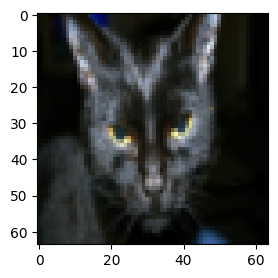

y = 1, it's a cat picture.


In [11]:
# Example of a picture
index =  26
plt.figure(figsize=(3,3))
plt.imshow(train_set_x_orig[index, :, :, :])
println("y = " * string(train_set_y[index]) * ", it's a " * classes[(train_set_y[index])+1] *  " picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
    - ```m_train``` (number of training examples)
    - ```m_test``` (number of test examples)
    - ```num_px``` (= ```height``` = ```width``` of a training image)
Remember that `train_set_x_orig` is an array of shape ```(m_train, num_px, num_px, 3)```. For instance, you can access `m_train` by writing `size(train_set_x_orig)[0]`.

In [12]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = size(train_set_x_orig)[1]
m_test = size(test_set_x_orig)[1]
num_px = size(train_set_x_orig)[2]
### END CODE HERE ###

println("Number of training examples: m_train = " * string(m_train))
println("Number of testing examples: m_test = " * string(m_test))
println("Height/Width of each image: num_px = " * string(num_px))
println("Each image is of size: (" * string(num_px) * ", " * string(num_px) * ", 3)")
println("train_set_x shape: " * string(size(train_set_x_orig)))
println("train_set_y shape: " * string(size(train_set_y)))
println("test_set_x shape: " * string(size(test_set_x_orig)))
println("test_set_y shape: " * string(size(test_set_y)))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for ```m_train```, ```m_test``` and ```num_px```**: 

| ```m_train``` | ```m_test``` | ```num_px``` |
|---------------|--------------|--------------|
| 209           | 50           | 64           |

For convenience, you should now reshape images of shape ```(num_px, num_px, 3)``` in an array of shape ```(num_px*num_px*3, 1)```. After this, our training (and test) dataset is an array where each column represents a flattened image. There should be ```m_train``` (respectively ```m_test```) columns.

**Exercise:** Reshape the training and test data sets so that images of size ```(num_px, num_px, 3)``` are flattened into single vectors of shape ```(num_px*num_px*3, 1)```.

A trick when you want to flatten a matrix ```X``` of shape ```(a,b,c,d)``` to a matrix ```X_flatten``` of shape ```(b*c*d, a)``` is to use: 

```julia
X_flatten = reshape(X, (b*c*d, a))
```

In [14]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = reshape(train_set_x_orig, (num_px*num_px*3, m_train))
test_set_x_flatten = reshape(test_set_x_orig, (num_px*num_px*3, m_test))
### END CODE HERE ###

println("train_set_x_flatten shape: " * string(size(train_set_x_flatten)))
println("train_set_y shape: " * string(size(train_set_y)))
println("test_set_x_flatten shape: " * string(size(test_set_x_flatten)))
println("test_set_y shape: " * string(size(test_set_y)))
println("sanity check after reshaping: " * string(train_set_x_flatten[1:6, 1]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17, 196, 82, 1, 9, 84]


**Expected Output**: 

| ```train_set_x_flatten shape``` | ```train_set_y shape``` | ```test_set_x_flatten shape``` | ```test_set_y shape``` | sanity check after reshaping |
|---------------------------------|-------------------------|-------------------------------:|------------------------|------------------------------|
| ```(12288, 209)```              | ```(1, 209)```          |              ```(12288, 50)``` | ```(1, 50)```          | ```[17, 196, 82, 1, 9, 84]```       |

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [16]:
train_set_x = train_set_x_flatten ./ 255
test_set_x = test_set_x_flatten ./ 255;

**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem ```(m_train, m_test, num_px, ...)```
- Reshape the datasets such that each example is now a vector of size ```(num_px * num_px * 3, 1)```
- "Standardize" the data

## 3 - General Architecture of the learning algorithm

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions.

In [19]:
# GRADED FUNCTION: sigmoid
"""
Compute the sigmoid of z

Arguments:
z -- A scalar or numpy array of any size.

Return:
s -- sigmoid(z)
"""
function sigmoid(z)
    
    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 ./ (1 .+ exp.(-z))
    ### END CODE HERE ###
    
    return s
end

sigmoid

In [20]:
println("sigmoid([0, 2]) = " * string(sigmoid([0, 2])))

sigmoid([0, 2]) = [0.5, 0.8807970779778823]


**Expected Output**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize ```w``` as a vector of zeros.

In [87]:
# GRADED FUNCTION: initialize_with_zeros
"""
This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

Argument:
dim -- size of the w vector we want (or number of parameters in this case)

Returns:
w -- initialized vector of shape (dim, 1)
b -- initialized scalar (corresponds to the bias)
"""
function initialize_with_zeros(dim)

    ### START CODE HERE ### (≈ 1 line of code)
    w = zeros((dim, 1))
    b = 0
    ### END CODE HERE ###

    @assert size(w) == (dim, 1)
    @assert isa(b, Float64) | isa(b, Int)
    
    return w, b
end

initialize_with_zeros

In [88]:
dim = 2
w, b = initialize_with_zeros(dim)
println("w = " * string(w))
println("b = " * string(b))

w = [0.0; 0.0]
b = 0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [89]:
# GRADED FUNCTION: propagate
"""
Implement the cost function and its gradient for the propagation explained above

Arguments:
w -- weights, an array of size (num_px * num_px * 3, 1)
b -- bias, a scalar
X -- data of size (num_px * num_px * 3, number of examples)
Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

Return:
cost -- negative log-likelihood cost for logistic regression
dw -- gradient of the loss with respect to w, thus same shape as w
db -- gradient of the loss with respect to b, thus same shape as b

Tips:
- Write your code step by step for the propagation. log(), dot()
"""
function propagate(w, b, X, Y)

    m = size(X)[2]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid((w' * X) .+ b)                                              # compute activation
    cost = - 1/m * (dot(Y, log.(A)) + dot(1 .- Y, log.(1 .- A)))    # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1/m * (X * (A .- Y)')
    db = 1/m * sum(A .- Y)
    ### END CODE HERE ###
    @assert size(dw) == size(w)
    @assert isa(db, Float64)
    @assert size(cost) == ()
    
    grads = Dict("dw" => dw,
             "db"=> db)
    
    return grads, cost
end

propagate

In [90]:
w, b, X, Y = [[1.]; [2.]], 2., [[1. 2. -1.]; [3. 4. -3.2]], [1 0 1]
w = reshape(w, (length(w), 1))
Y = reshape(Y, (1, length(Y)))
grads, cost = propagate(w, b, X, Y)
println("dw = " * string(grads["dw"]))
println("db = " * string(grads["db"]))
println("cost = " * string(cost))

dw = [0.998456014637956; 2.3950723884862066]
db = 0.001455578136784208
cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [0.998456014637956; 2.3950723884862066]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [93]:
# GRADED FUNCTION: optimize
"""
This function optimizes w and b by running a gradient descent algorithm

Arguments:
w -- weights, a numpy array of size (num_px * num_px * 3, 1)
b -- bias, a scalar
X -- data of shape (num_px * num_px * 3, number of examples)
Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
num_iterations -- number of iterations of the optimization loop
learning_rate -- learning rate of the gradient descent update rule
print_cost -- True to print the loss every 100 steps

Returns:
params -- dictionary containing the weights w and bias b
grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
costs -- list of all the costs computed during the optimization, 
         this will be used to plot the learning curve.

Tips:
You basically need to write down two steps and iterate through them:
    1) Calculate the cost and the gradient for the current parameters. Use propagate().
    2) Update the parameters using gradient descent rule for w and b.
"""
function optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = false)
    
    costs = []
    
    for i in 1: num_iterations
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w .- learning_rate.*dw
        b = b .- learning_rate.*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0
            append!(costs, cost)
        end
        # Print the cost every 100 training iterations
        if print_cost && i % 100 == 0
            println("Cost after iteration $(i): $(cost)")
        end
        
        grads = Dict("dw" => dw,
             "db" => db)
        params = Dict("w" => w,
              "b" => b)
              
    end

    
    return params, grads, costs
end

optimize

In [95]:
params, grads, costs = optimize(w, b, X, Y, 100, 0.009, false)

println("w = " * string(params["w"]))
println("b = " * string(params["b"]))
println("dw = " * string(grads["dw"]))
println("db = " * string(grads["db"]))

w = [0.19033590888604332; 0.12259159246561413]
b = 1.9253598300845747
dw = [0.998456014637956; 2.3950723884862066]
db = 0.001455578136784208
